# Análise de dados de tipos de estrela

Neste projeto, iremos a analisar uma base de dados de características de estrelas coletados pela NASA. 
A base está disponível [no Kaggle](https://www.kaggle.com/brsdincer/star-type-classification), começaremos observando o que a base nos fornece de dados, e então testaremos os algoritmos de classificação para achar o que melhor ajuda a prever o tipo de estrela baseado nos demais atributos e por fim mostraremos alguns gráficos baseados nos atributos e como elas se diferem em si.

Primeiramento vamos importar as bibliotecas necessárias e importar os dados:

In [44]:
!pip install category_encoders
# discriminante linear e quadrático
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# naive bayes, com distribuição gaussiana
from sklearn.naive_bayes import GaussianNB

# faz uma transformação de escala nos atributos, para que tenham média zero e desvio padrão 1
from sklearn.preprocessing import StandardScaler

# carregamento de dados artificiais do sitem OpenML
from sklearn.datasets import make_moons, make_circles, fetch_openml

from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, make_scorer, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics.scorer import roc_auc_scorer, accuracy_scorer

#Avaliação cruzada
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold

# transformação de atributos
from category_encoders import OneHotEncoder, OrdinalEncoder

import seaborn as sns # gráficos

import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import pandas as pd
from collections import Counter

Defaulting to user installation because normal site-packages is not writeable


In [45]:
#buscando os dados
data = pd.read_csv('Stars.csv')

A seguir temos os dados um resumo dos primeiros dados da base:

In [46]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Agora vamos ver rapidamente os dados categoricos, começando pelas cores das estrelas, 'e not'avel que algumas cores sao repetidas ("Blue White", "Blue white" e "Blue-white") entao teremos de tratar isso mais tarde. Segue abaixo os dados das cores das estrelas:

In [47]:
print(pd.unique(data["Color"]))

['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']


Sobre a classe espectral, pode se ver o que eles significam [aqui] (https://en.wikipedia.org/wiki/Asteroid_spectral_types)

Abaixo os diferentes tipos espectrais das estrelas da base:

In [48]:
print(pd.unique(data["Spectral_Class"]))

['M' 'B' 'A' 'F' 'O' 'K' 'G']


Apesar da coluna "Type" aparentar ser numérica ela é categórica, pois os códigos (de 0 a 5), ent~ao optamos por criar um objeto para representar os tipos:

In [49]:
nomes_tipos_estrelas = {
    'Red Dwarf': 0,
    'Brown Dwarf': 1,
    'White Dwarf': 2,
    'Main Sequence': 3,
    'Super Giants': 4,
    'Hyper Giants': 5
}

Vamos começar compararando dados categóricos com outros categóricos, comparando o tipo espectral (`Spectral_Class`) com o tipo da estrela (`Type`):

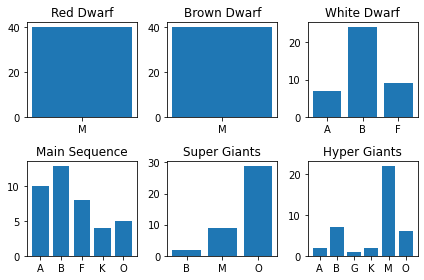

In [50]:
#aqui declaramos o conjunto vazio que vai guardar os dados agregados para cada tipo de estrela
datasets_tipos_espectros = []

#para cada tipo vamos calcular o qual a frequencia de cada espectro
for tipo in pd.unique(data['Type']):
    estrelas_de_um_tipo = data[data.Type == tipo]

    count_espectros = estrelas_de_um_tipo.groupby('Spectral_Class').agg({'Spectral_Class': ['count']})
    
    count_espectros.columns = ['quantidade']
    
    datasets_tipos_espectros.append(count_espectros)

    
figure, axis = plt.subplots(2,3)
i = j = 0

datasets_tipos_espectros[0].head()

for nome, indice in nomes_tipos_estrelas.items():
 
    estrelas = datasets_tipos_espectros[indice]
    
    x = estrelas.index
    y = estrelas['quantidade']
    
    axis[i, j].bar(x, y)
    axis[i, j].set_title(nome)
    
    j = j + 1
    if indice == 2:
        j = 0
        i = 1

plt.tight_layout()        
plt.show()

Agora vamos ver como é a distribuição da temperatura das estrelas para cada tipo:

/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

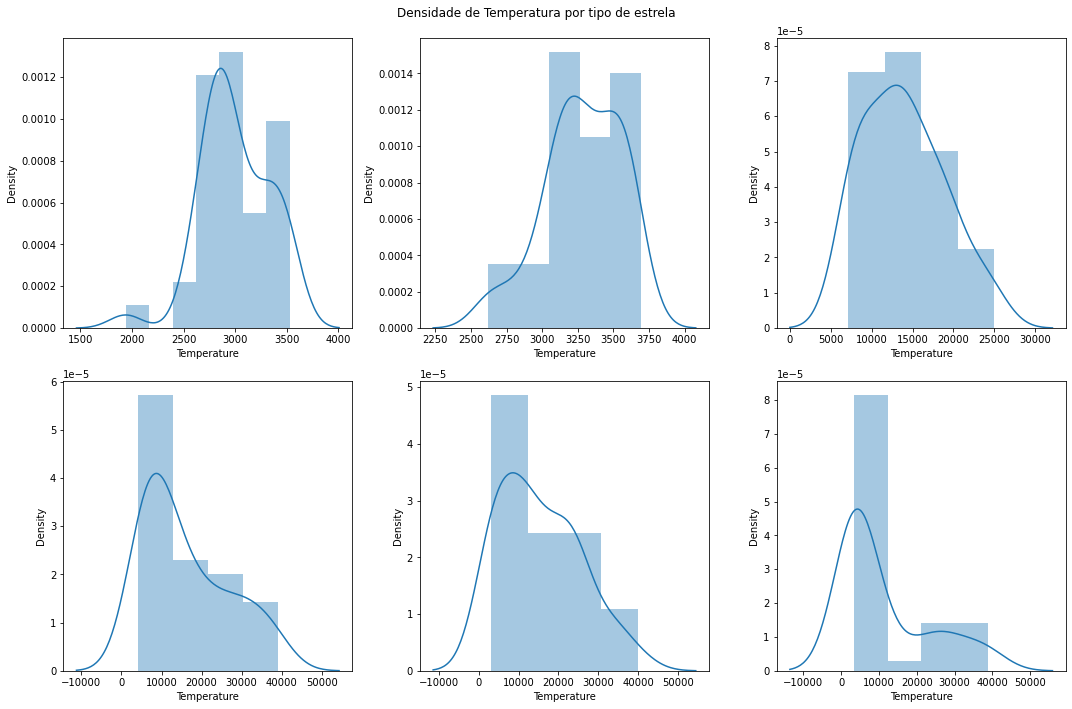

In [54]:
figure, axis = plt.subplots(2,3, figsize=(15, 10))
figure.suptitle('Densidade de Temperatura por tipo de estrela')
i = j = 0

for nome, indice in nomes_tipos_estrelas.items():
 
    estrelas = data[data.Type == indice]
    total_temperatura = estrelas['Temperature']

    plt.subplot(2, 3, indice+ 1)
    sns.distplot(total_temperatura)
    #axis[i, j].set_title(nome)

    j = j + 1

    if indice == 2:
        j = 0;
        i = 1

plt.tight_layout()
plt.show()

# Classificacao
Agora chegamos na etapa de ver qual o melhor algoritmo de classificacao dos vistos em aula para prever o tipo de estrela baseados nos demais atributos da base. Primeiro precisamos tratar algumas colunas, comecando pela coluna `Color` pois a mesma esta com dados duplicados, e por se tratar de dados nominais vamos transforma-los em numericos:

In [19]:
print(pd.unique(data['Color']))

['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']


Comecando unificando as cores que sao iguais mas estao digitadas de modo distinto:

In [20]:
def tratar_cores(str):
    if str in ['Blue white', 'Blue White', 'Blue-White', 'Blue-white']:
        return 'blue-white'
    elif str in ['yellowish','Yellowish']:
        return 'yellowish'
    elif str in ['White-Yellow', 'Yellowish White', 'yellow-white']:
        return 'yellowish-white'
    elif str in ['White', 'white', 'Whitish']:
        return 'white'
    else:
        return str
    
data['Color'] = data.apply(lambda x: tratar_cores(x['Color']), axis=1)

print(pd.unique(data['Color']))

['Red' 'blue-white' 'white' 'yellowish-white' 'Pale yellow orange' 'Blue'
 'Orange' 'yellowish' 'Orange-Red']


Antes de convertermos os valores de `Color` para numericos vamos mapear a coluna `Spectral_Class`, pode nao parecer de inicio que a mesma se trata de uma coluna ordinal, mas e possivel atribuir ordem para as classes espectrais das estrelas [como pode ser visto neste artigo na pagina 8](http://www3.uma.pt/Investigacao/Astro/Grupo/Publicacoes/Pub/Modulos/estrelas1.pdf). Desse modo o mapeamento segue abaixo:


In [21]:
mappings = [
    {
     'col' : 'Spectral_Class',
     'mapping' : {
         'M' : 0,
         'K' : 1,
         'G' : 2,
         'F' : 3,
         'A' : 4,
         'B' : 5,
         'O' : 6
     }
    }
]

onehotenc = OneHotEncoder(cols = ['Color'])
ordinalenc = OrdinalEncoder(cols = ['Spectral_Class'])

data2 = onehotenc.fit_transform(data)
data3 = ordinalenc.fit_transform(data2, mapping = mappings)
data3.head()

/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Temperature,L,R,A_M,Color_1,Color_2,Color_3,Color_4,Color_5,Color_6,Color_7,Color_8,Color_9,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,1,0,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,1,0,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,1,0,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,1,0,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,1,0,0,0,0,0,0,0,0,1,0


Agora finalmente chegamos na parte de medir a acuracia dos algoritmos de classificacao:

In [57]:
#definindo os classificadores que testaremos 
classificadores = {
    'Naive Bayes (Gaussian)' : GaussianNB(),
    'Discriminante Linear' : LinearDiscriminantAnalysis(),
    'Discriminante Quadrático' : QuadraticDiscriminantAnalysis()
}

#O unico criterio de avaliacao que estamos interessado e acuracia
scoring = {'accuracy': accuracy_scorer}

results = []

for clf_name, clf in classificadores.items():
    temp = cross_validate(clf, data3, data3["Type"], cv=10, scoring=scoring, return_train_score=True)
    temp['clf'] = [clf_name]*10
    temp['fold'] = range(10)

    results.append(pd.DataFrame(temp))

results = pd.concat(results)


count_espectros = estrelas_de_um_tipo.groupby('Spectral_Class').agg({'Spectral_Class': ['count']})

results.groupby('clf').agg({'train_accuracy': ['median', 'mean', 'min', 'max'], 'test_accuracy': ['median', 'mean', 'min', 'max']})

/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/vitorguilherm

AttributeError: 'SeriesGroupBy' object has no attribute 'average'